In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense,
    Embedding,
    LSTM,
    GlobalMaxPooling1D,
    Conv1D,
    Dropout,
    Bidirectional,
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

<IPython.core.display.Javascript object>

In [3]:
warnings.filterwarnings("ignore")
print("Tensorflow version =", tf.__version__)

Tensorflow version = 2.3.1


<IPython.core.display.Javascript object>

# Bidirectional LSTM

## Setup

In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs detected")

1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [5]:
# if len(gpus)==1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
# else: strategy = tf.distribute.MirroredStrategy()

<IPython.core.display.Javascript object>

In [6]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print("Mixed precision enabled")

Mixed precision enabled


<IPython.core.display.Javascript object>

In [7]:
args = dict(
    data_dir=Path("../input"),
    train_csv=Path("../input/train.csv"),
    test_csv=Path("../input/test_x.csv"),
    sample_csv=Path("../input/sample_submission.csv"),
    target_col="author",
    feature_dir=Path("../build/feature"),
    val_dir=Path("../build/val"),
    test_dir=Path("../build/test"),
    subm_dir=Path("../build/subm"),
    n_folds=5,
    n_classes=5,
    seed=42,
)

<IPython.core.display.Javascript object>

In [8]:
algo_name = "lstm"
feature_name = "emb"
model_name = f"{algo_name}_{feature_name}"

feature_file = args["feature_dir"] / f"{feature_name}.csv"
p_val_file = args["val_dir"] / f"{model_name}.csv"
p_test_file = args["test_dir"] / f"{model_name}.csv"
subm_file = args["subm_dir"] / f"{model_name}.csv"

<IPython.core.display.Javascript object>

## Data

In [9]:
train = pd.read_csv(args["train_csv"], index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


<IPython.core.display.Javascript object>

In [10]:
test = pd.read_csv(args["test_csv"], index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


<IPython.core.display.Javascript object>

## Preprocessing

In [11]:
def alpha_num(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in STOPWORDS:
            final_text.append(i.strip())
    return " ".join(final_text)


STOPWORDS = [
    "a",
    "about",
    "above",
    "after",
    "again",
    "against",
    "all",
    "am",
    "an",
    "and",
    "any",
    "are",
    "as",
    "at",
    "be",
    "because",
    "been",
    "before",
    "being",
    "below",
    "between",
    "both",
    "but",
    "by",
    "could",
    "did",
    "do",
    "does",
    "doing",
    "down",
    "during",
    "each",
    "few",
    "for",
    "from",
    "further",
    "had",
    "has",
    "have",
    "having",
    "he",
    "he'd",
    "he'll",
    "he's",
    "her",
    "here",
    "here's",
    "hers",
    "herself",
    "him",
    "himself",
    "his",
    "how",
    "how's",
    "i",
    "i'd",
    "i'll",
    "i'm",
    "i've",
    "if",
    "in",
    "into",
    "is",
    "it",
    "it's",
    "its",
    "itself",
    "let's",
    "me",
    "more",
    "most",
    "my",
    "myself",
    "nor",
    "of",
    "on",
    "once",
    "only",
    "or",
    "other",
    "ought",
    "our",
    "ours",
    "ourselves",
    "out",
    "over",
    "own",
    "same",
    "she",
    "she'd",
    "she'll",
    "she's",
    "should",
    "so",
    "some",
    "such",
    "than",
    "that",
    "that's",
    "the",
    "their",
    "theirs",
    "them",
    "themselves",
    "then",
    "there",
    "there's",
    "these",
    "they",
    "they'd",
    "they'll",
    "they're",
    "they've",
    "this",
    "those",
    "through",
    "to",
    "too",
    "under",
    "until",
    "up",
    "very",
    "was",
    "we",
    "we'd",
    "we'll",
    "we're",
    "we've",
    "were",
    "what",
    "what's",
    "when",
    "when's",
    "where",
    "where's",
    "which",
    "while",
    "who",
    "who's",
    "whom",
    "why",
    "why's",
    "with",
    "would",
    "you",
    "you'd",
    "you'll",
    "you're",
    "you've",
    "your",
    "yours",
    "yourself",
    "yourselves",
]

<IPython.core.display.Javascript object>

In [12]:
train["text"] = train["text"].str.lower().apply(alpha_num).apply(remove_stopwords)
test["text"] = test["text"].str.lower().apply(alpha_num).apply(remove_stopwords)

<IPython.core.display.Javascript object>

In [13]:
x_trn = train["text"].values
x_test = test["text"].values
y = train["author"].values
x_trn.shape, x_test.shape, y.shape

((54879,), (19617,), (54879,))

<IPython.core.display.Javascript object>

In [14]:
x_trn[:3]

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'],
      dtype=object)

<IPython.core.display.Javascript object>

## Train

In [15]:
vocab_sz = 20_000
embed_dim = 64
maxlen = 500
padding = "post"

<IPython.core.display.Javascript object>

In [16]:
tokenizer = Tokenizer(num_words=vocab_sz)
tokenizer.fit_on_texts(x_trn)
word_index = tokenizer.word_index

<IPython.core.display.Javascript object>

In [17]:
trn_seqs = tokenizer.texts_to_sequences(x_trn)
test_seqs = tokenizer.texts_to_sequences(x_test)

<IPython.core.display.Javascript object>

In [18]:
trn = pad_sequences(trn_seqs, padding=padding, maxlen=maxlen)
test = pad_sequences(test_seqs, padding=padding, maxlen=maxlen)
trn.shape, test.shape

((54879, 500), (19617, 500))

<IPython.core.display.Javascript object>

In [19]:
cv = model_selection.StratifiedKFold(
    n_splits=args["n_folds"], shuffle=True, random_state=args["seed"]
)

<IPython.core.display.Javascript object>

In [20]:
def get_model():
    model = Sequential(
        [
            Embedding(vocab_sz, embed_dim, input_length=maxlen),
            Bidirectional(LSTM(64, return_sequences=True)),
            Bidirectional(LSTM(64)),
            Dense(args["n_classes"], activation="softmax"),
        ]
    )

    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01))
    return model

<IPython.core.display.Javascript object>

In [24]:
p_val = np.zeros((train.shape[0], args["n_classes"]))
p_test = np.zeros((test.shape[0], args["n_classes"]))

for fold, (trn_, val_) in enumerate(cv.split(trn, y)):
    print(f"Training model for fold #{fold}...")

    x_trn, y_trn = trn[trn_], y[trn_]
    x_val, y_val = trn[val_], y[val_]

    model = get_model()
    es = EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=3,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

    model.fit(
        x_trn,
        to_categorical(y_trn),
        validation_data=(x_val, to_categorical(y_val)),
        epochs=20,
        batch_size=512,
        callbacks=[es],
    )

    p_val[val_] = model.predict(x_val)
    p_test += model.predict(test) / args["n_folds"]

Training model for fold #0...
Epoch 1/20
86/86 [==============================] - 17s 196ms/step - loss: 1.0848 - val_loss: 0.8242
Epoch 2/20
86/86 [==============================] - 16s 191ms/step - loss: 0.5862 - val_loss: 0.7250
Epoch 3/20
86/86 [==============================] - 16s 190ms/step - loss: 0.4227 - val_loss: 0.7913
Epoch 4/20
86/86 [==============================] - 16s 191ms/step - loss: 0.3392 - val_loss: 0.8697
Epoch 5/20
86/86 [==============================] - 16s 190ms/step - loss: 0.2800 - val_loss: 0.9880
Epoch 00005: early stopping
Training model for fold #1...
Epoch 1/20
86/86 [==============================] - 17s 198ms/step - loss: 1.0671 - val_loss: 0.7885
Epoch 2/20
86/86 [==============================] - 16s 192ms/step - loss: 0.5732 - val_loss: 0.7451
Epoch 3/20
86/86 [==============================] - 16s 191ms/step - loss: 0.4186 - val_loss: 0.7845
Epoch 4/20
86/86 [==============================] - 17s 193ms/step - loss: 0.3312 - val_loss: 0.8839
Epo

<IPython.core.display.Javascript object>

In [26]:
accuracy = metrics.accuracy_score(y, np.argmax(p_val, axis=-1))
log_loss = metrics.log_loss(pd.get_dummies(y), p_val)
print(f"Accuracy (CV): {accuracy:8.4f}")
print(f"Log Loss (CV): {log_loss:8.4f}")

Accuracy (CV):   0.7289
Log Loss (CV):   0.7349


<IPython.core.display.Javascript object>

In [27]:
np.savetxt(p_val_file, p_val, fmt="%.6f", delimiter=",")
np.savetxt(p_test_file, p_test, fmt="%.6f", delimiter=",")

<IPython.core.display.Javascript object>

## Visualization

In [28]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 64)           1280000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 500, 128)          66048     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 1,445,509
Trainable params: 1,445,509
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

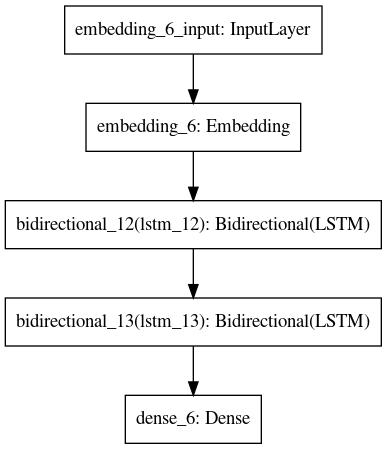

<IPython.core.display.Javascript object>

In [29]:
plot_model(model)

## Submission

In [30]:
subm = pd.read_csv(args["sample_csv"], index_col=0)
subm[subm.columns] = p_test
subm.head()

,0,1,2,3,4
index,,,,,
0,0.058852,0.336574,0.468319,0.122551,0.013703
1,0.138280,0.480891,0.016365,0.045293,0.319171
2,0.872093,0.102348,0.010649,0.005855,0.009056
3,0.013870,0.008742,0.877104,0.051134,0.049150
4,0.374121,0.066719,0.037064,0.417482,0.104614


<IPython.core.display.Javascript object>

In [32]:
subm.to_csv(subm_file)

<IPython.core.display.Javascript object>